# Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import sklearn
import imgaug
import tensorflow as tf
import random
import cv2
import os
import pathlib
import joblib # for saving the model

from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

def version(module, version):
    v = module.__version__
    if v != version:
        print(f"{module.__name__} version: {v} ❌ (need {version})")
    else:
        print(f"{module.__name__} version: {v} ✅")

# Check the version of the packages, you can skip this if you are not encountering any errors
version(np, "1.25.2")
version(tf, "2.15.0")
version(keras, "2.15.0")
version(sklearn, "1.2.2")
version(imgaug, "0.4.0")


numpy version: 1.25.2 ✅
tensorflow version: 2.15.0 ✅
keras version: 2.15.0 ✅
sklearn version: 1.2.2 ✅
imgaug version: 0.4.0 ✅


# Mount google drive (for google colab)

In [2]:
from google.colab import drive

if (not os.path.exists('/content/drive')):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

Mounted at /content/drive


# Project directory

In [2]:
def resolve(*args):
    return pathlib.Path(os.path.join(*args)).resolve()

PROJECT_DIR = resolve('..')
# PROJECT_DIR = resolve('/content/drive', "MyDrive/Colab Notebooks/fingerprint-recognition")
subfolders = [ f.path for f in os.scandir(PROJECT_DIR) if f.is_dir() ]
print(f"Project directory: {PROJECT_DIR}")
print(f"Subfolders: {subfolders}")

Project directory: D:\workspace\python\fingerprint-recognition
Subfolders: ['D:\\workspace\\python\\fingerprint-recognition\\.git', 'D:\\workspace\\python\\fingerprint-recognition\\database', 'D:\\workspace\\python\\fingerprint-recognition\\dataset-enhanced', 'D:\\workspace\\python\\fingerprint-recognition\\dataset-original', 'D:\\workspace\\python\\fingerprint-recognition\\dataset-raw', 'D:\\workspace\\python\\fingerprint-recognition\\result', 'D:\\workspace\\python\\fingerprint-recognition\\src']


# Load Dataset

In [6]:
DATASET_TYPE = "enhanced" # "enhanced" or "original"
DATASET = [
    "Real",
    "Altered/Altered-Easy",
    "Altered/Altered-Medium",
    "Altered/Altered-Hard",
]
data_dict = {
    dataset: np.load(resolve(PROJECT_DIR, f"dataset-{DATASET_TYPE}", dataset, "data.npz"), allow_pickle=True)["arr_0"]
    for dataset in DATASET
}
dataset2 = np.load(resolve(PROJECT_DIR, f"dataset-enhanced/Real/data2.npz"), allow_pickle=True)["arr_0"]
data_dict["Real"] = np.concatenate((data_dict["Real"], dataset2), axis=0)
imgs_dict = {
    dataset: np.array([data[0] for data in data_dict[dataset]])
    for dataset in DATASET
}
labels_dict = {
    dataset: np.array([data[1] for data in data_dict[dataset]])
    for dataset in DATASET
}

print(f"Shape of Real dataset: {imgs_dict['Real'].shape}")
print(f"Shape of Altered-Easy dataset: {imgs_dict['Altered/Altered-Easy'].shape}")
print(f"Shape of Altered-Medium dataset: {imgs_dict['Altered/Altered-Medium'].shape}")
print(f"Shape of Altered-Hard dataset: {imgs_dict['Altered/Altered-Hard'].shape}")

Shape of Real dataset: (6000, 90, 90, 1)
Shape of Altered-Easy dataset: (17905, 90, 90, 1)
Shape of Altered-Medium dataset: (17021, 90, 90, 1)
Shape of Altered-Hard dataset: (14243, 90, 90, 1)


# Train Test Split

In [7]:
img_data = np.concatenate(list(imgs_dict.values()), axis=0)
label_data = np.concatenate(list(labels_dict.values()), axis=0)

img_train, img_val, label_train, label_val = sklearn.model_selection.train_test_split(img_data, label_data, test_size=0.1)

print(f"Shape of img_train: {img_train.shape}")
print(f"Shape of img_val: {img_val.shape}")
print(f"Shape of label_train: {label_train.shape}")
print(f"Shape of label_val: {label_val.shape}")

Shape of img_train: (49652, 90, 90, 1)
Shape of img_val: (5517, 90, 90, 1)
Shape of label_train: (49652, 4)
Shape of label_val: (5517, 4)


# Make Label Dictionary Lookup Table

In [8]:
label_real_dict = {}

def get_match_key(y):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    return key

for i, y in enumerate(labels_dict["Real"]):
    key = get_match_key(y)
    label_real_dict[key] = i
print(label_real_dict)
# print(label_train)

{'101010': 0, '100012': 1, '101011': 2, '101013': 3, '100014': 4, '100004': 5, '100001': 6, '101001': 7, '101000': 8, '101012': 9, '101014': 10, '102011': 11, '102004': 12, '100010': 13, '101002': 14, '101003': 15, '102003': 16, '102001': 17, '101004': 18, '100003': 19, '102002': 20, '100013': 21, '102000': 22, '100002': 23, '100000': 24, '100011': 25, '102014': 26, '102012': 27, '102013': 28, '103101': 29, '102010': 30, '103104': 31, '103102': 32, '103103': 33, '103111': 34, '103100': 35, '103113': 36, '104004': 37, '104014': 38, '104011': 39, '104003': 40, '103114': 41, '104000': 42, '103112': 43, '103110': 44, '104001': 45, '105004': 46, '104013': 47, '104002': 48, '105001': 49, '104010': 50, '104012': 51, '105002': 52, '105003': 53, '105000': 54, '105011': 55, '105013': 56, '105014': 57, '106001': 58, '105010': 59, '106002': 60, '105012': 61, '106003': 62, '106004': 63, '107004': 64, '107003': 65, '107011': 66, '106011': 67, '106013': 68, '106000': 69, '107001': 70, '107014': 71, '

# Preview Augmentation

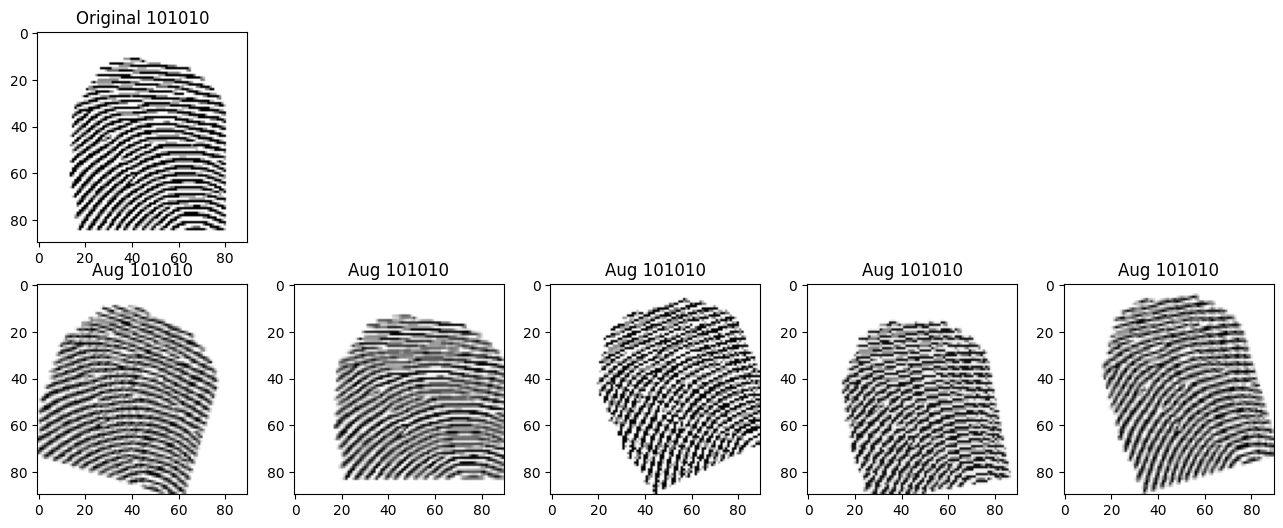

In [9]:
augs = [img_data[0]] * 5

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)
plt.figure(figsize=(16, 6))

label = get_match_key(label_data[0])

plt.subplot(2, 5, 1)
plt.title(f'Original {label}')
plt.imshow(img_data[0].squeeze(), cmap='gray')

# Preview augmentation
for i, aug in enumerate(augs):
    plt.subplot(2, 5, 5 + i+1)
    plt.title(f'Aug {label}')
    plt.imshow(aug.squeeze(), cmap='gray')

# Create DataGenerator

In [18]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        "Initialization"
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):

        "Generate one batch of data"
        # Generate indexes of the batch
        x1_batch = self.x[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch = self.label[
            index * self.batch_size : (index + 1) * self.batch_size
        ]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # augmentation
        if self.shuffle:
            seq = iaa.Sequential(
                [
                    iaa.GaussianBlur(sigma=(0, 0.5)),
                    iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-30, 30),
                        order=[0, 1],
                        cval=255,
                    ),
                ],
                random_order=True,
            )

            x1_batch = seq.augment_images(x1_batch)
            # for img in x1_batch:
            #     img = Gabor(img)

        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010

        for i, l in enumerate(label_batch):
            try:
                match_key = get_match_key(l)

                if random.random() > 0.5:
                    # put matched image
                    x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                    y_batch[i] = 1.0
                else:
                    # put unmatched image
                    while True:
                        unmatch_key, unmatch_idx = random.choice(
                            list(self.label_real_dict.items())
                        )

                        if unmatch_key != match_key:
                            break

                    x2_batch[i] = self.x_real[unmatch_idx]
                    y_batch[i] = 0.0
            except:
                print("e", get_match_key(l))
                continue

        return [
            x1_batch.astype(np.float32) / 255.0,
            x2_batch.astype(np.float32) / 255.0,
        ], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)


# Create data generator
train_gen = DataGenerator(
    img_train, label_train, imgs_dict["Real"], label_real_dict, shuffle=True
)
val_gen = DataGenerator(
    img_val, label_val, imgs_dict["Real"], label_real_dict, shuffle=False
)

# Create Model

In [19]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

# model
model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 22, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 22, 22, 32)           0         ['model[0][0]',      

# Train

In [20]:
tf.debugging.disable_traceback_filtering()
history = model.fit(train_gen, epochs=16, validation_data=val_gen)

Epoch 1/16


 505/1551 [========>.....................] - ETA: 54s - loss: 0.4581 - acc: 0.7689

KeyboardInterrupt: 

# Save model

In [14]:
FILE_PATH = resolve(PROJECT_DIR, 'result/finalized_model.pkl')

os.makedirs(resolve(PROJECT_DIR, 'result'), exist_ok=True)
joblib.dump(model, FILE_PATH)
print(f"Model saved to {FILE_PATH}")

Model saved to /content/drive/MyDrive/Colab Notebooks/fingerprint-recognition/result/finalized_model.pkl


# Load model (for pre-trained model only)

In [10]:
FILE_PATH = resolve(PROJECT_DIR, 'result/finalized_model2.h5')

# Load the trained model
model = tf.keras.models.load_model(FILE_PATH)
print(f"Model loaded from {FILE_PATH}")



Model loaded from D:\workspace\python\fingerprint-recognition\result\finalized_model2.h5


# Evaluation

1/1 [==============================] - 0s 17ms/step
1.0 2


C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_29048\3952923024.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(round(float(pred_rx), 2), 2)
C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_29048\3952923024.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Input {get_match_key(ry)}: {round(float(pred_rx), 2)}')
C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_29048\3952923024.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title

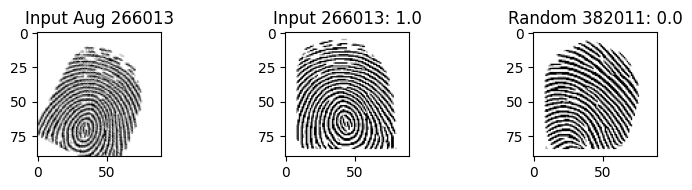

In [13]:
# new user fingerprint input
random_idx = random.randint(0, len(img_val))

random_img = img_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = imgs_dict["Real"][label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = labels_dict["Real"][label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = imgs_dict["Real"][unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = labels_dict["Real"][unmatch_idx]

pred_ux = model.predict([random_img, ux])
print(round(float(pred_rx), 2), 2)

plt.figure(figsize=(8, 4))
plt.subplots_adjust(wspace=1)
plt.subplot(1, 3, 1)
plt.title(f"Input Aug {get_match_key(ry)}")
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title(f'Input {get_match_key(ry)}: {round(float(pred_rx), 2)}')
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title(f"Random {get_match_key(uy)}: {round(float(pred_ux), 2)}")
plt.imshow(ux.squeeze(), cmap='gray')

# Gabor util

In [12]:
def apply_sliding_window_on_1_channel(img, kernel):
    return cv2.filter2D(src=img, ddepth=-1, kernel=kernel)


def generate_gabor_bank(
    num_kernels, ksize=(15, 15), sigma=3, lambd=7.3, gamma=0.25, psi=0
):
    bank = []
    theta = 0
    step = np.pi / num_kernels
    for idx in range(num_kernels):
        theta = idx * step
        kernel = cv2.getGaborKernel(
            ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi
        )
        bank.append(kernel)
    return bank


def Gabor(img):
    img = cv2.resize(img, (7 * 96, 7 * 103))
    gabor_bank = generate_gabor_bank(num_kernels=16)
    avg_out = np.zeros(img.shape)

    for idx, kernel in enumerate(gabor_bank):
        res = apply_sliding_window_on_1_channel(img, kernel)
        avg_out += res

    avg_out = avg_out / len(gabor_bank)
    avg_out = avg_out.astype(np.uint8)
    avg_out = cv2.resize(avg_out, (90, 90))
    return avg_out

# Thread pool

In [14]:
import queue
import threading

class ThreadPool:
    def __init__(self, num_threads=os.cpu_count(), verbose=True):
        self.verbose = verbose
        self.workers = []
        self.num_threads = num_threads
        self.tasks = queue.Queue()
        self.results = queue.Queue()
        self.size = 0
        self.count = 0

        for _ in range(num_threads):
            worker = threading.Thread(target=self._worker)
            worker.daemon = True  # Threads will terminate when the main program ends
            worker.start()
            self.workers.append(worker)

    def _worker(self):
        while True:
            func, args, kwargs = self.tasks.get()
            try:
                result = func(*args, **kwargs)
                self.results.put(result)  # Put result into results queue
                self.count += 1
                percent = float("{:.1f}".format(self.count / self.size * 100))
                if self.verbose == True:
                    print(
                        f"========== Done ({self.count}/{self.size}) {percent}% =========="
                    )
            except Exception as e:
                print(f"Error executing function: {e}")
            finally:
                self.tasks.task_done()

    def reset(self, size):
        # ! MUST CALL THIS METHOD BEFORE ADDING NEW TASKS
        with self.tasks.mutex:
            self.tasks.queue.clear()
        with self.results.mutex:
            self.results.queue.clear()
        self.size = size
        self.count = 0

    def add_task(self, func, *args, **kwargs):
        self.tasks.put((func, args, kwargs))

    def wait_completion(self):
        self.tasks.join()

# Create thread pool with number of threads equal to CPU cores count
THREAD_COUNT = 6 or os.cpu_count()
thread_pool = ThreadPool(num_threads=THREAD_COUNT, verbose=False)
print(f"Created thread_pool with {THREAD_COUNT} thread, current cpu cores: {os.cpu_count()}")

Created thread_pool with 6 thread, current cpu cores: 12


# Predict

Input 100003
1/1 [==============================] - 0s 19ms/step
0.9998333333333334 False
Match 100003: 0.9872599840164185


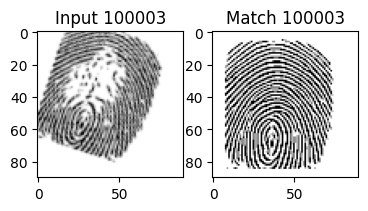

In [23]:
MAX_LEN = 20
MIN_PER = 0.95
CHOOSE_DATASET="Altered/Altered-Hard"

choose = random.randint(0, len(imgs_dict[CHOOSE_DATASET][:MAX_LEN]))
img = imgs_dict[CHOOSE_DATASET][choose]
label = labels_dict[CHOOSE_DATASET][choose]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

plt.subplot(1, 3, 1)
plt.title(f'Input {get_match_key(label)}')
plt.imshow(img.squeeze(), cmap='gray')
count = 0

def process(i):
    tmp_img = imgs_dict["Real"][i].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    tmp_label = get_match_key(labels_dict["Real"][i])
    pred = model.predict([img, tmp_img])
    score = round(np.max(pred), 5)
    return score, tmp_label

best_score = 0
best_label = ""
best_i = 0
print(f"Input {get_match_key(label)}")
for i in range(len(imgs_dict["Real"][:MAX_LEN])):
    score, tmp_label = process(i)
    if (score > best_score and score > MIN_PER):
      best_score = score
      best_label = tmp_label
      best_i = i

print(1 - (1/6000), 1 - (1/6000) < best_score)

plt.subplot(1, 3, 2)
plt.title(f"Match {best_label}")
plt.imshow(imgs_dict["Real"][best_i].squeeze(), cmap='gray')
print(f"Match {best_label}: {best_score}")